# Idea is to compare runs of cue with all lines, no low-ionization lines, and no argon and sulfur lines in here

what to compare:

    predictions of [S II], [O I], [S III], [Ar IIII]

In [1]:
import numpy as np
import dill as pickle
import matplotlib
from matplotlib import pyplot as plt
from pkg_resources import resource_filename
import cue
from cue.line import predict
from cue.utils import (c, cont_lam, new_sorted_line_name, 
                       logQ, Qtotal,
                       get_loglinear_spectra, ionparam2norm, calcQ) # this includes some constants and functions for the fits and output plots

/tmp/ipykernel_19007/3108464471.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
2025-10-31 18:57:13.225820: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-31 18:57:13.226169: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 18:57:13.265322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AV

In [2]:
# first: we have to readin the galaxy observed lines
galaxy = "D40"
with open("line_luminosities/"+galaxy+".pkl", 'rb') as f:
    obs = pickle.load(f)
obs.keys()

wav_ind, = np.where((obs['line_lum']!=0) | (obs['line_lum_up']!=0))
wav_ind_obs, = np.where(obs['line_lum']!=0)  # indices where line is observed
wav_ind_up, = np.where(obs['line_lum_up']!=0)

# S/N of the observation
SN_obs = np.zeros_like(obs['line_lum'])
SN_obs[wav_ind_obs] = obs['line_lum'][wav_ind_obs]/obs['line_lum_unc'][wav_ind_obs] 
SN_obs[wav_ind_up] = 3

# S/N of the emulator test data set, here the noise is the emulator uncertainty
with open(resource_filename("cue", "data/nn_stats_v0.pkl"), 'rb') as f:
       nn_stats = pickle.load(f)
SN_nn = nn_stats['SN_quantile'][1][np.argsort(nn_stats['wav'])]

# combine the observed SN and the emulator SN to estimate the noise for the measured lines
SN_obs[wav_ind_obs] = 1./np.sqrt(1./SN_obs[wav_ind_obs]**2 + 1./SN_nn[wav_ind_obs]**2)
line_noise = np.zeros_like(obs['line_lum'])
line_noise[wav_ind_obs] = (obs['line_lum'][wav_ind_obs]/SN_obs[wav_ind_obs])
line_noise[wav_ind_up] = obs['line_lum_unc'][wav_ind_up]
line_var = line_noise**2

In [ ]:
def get_linepredictions_forarun(results_file):
    with open(results_file, 'rb') as f:
        cue_results = pickle.load(f)
    cue_results.keys()

    # median and 1-sigma range of the emission line and nebular continuum
    from dynesty.utils import resample_equal
    theta_arr = resample_equal(cue_results.samples, np.exp(cue_results.logwt-cue_results.logz[-1]), rstate=None)

    line_pred = list()
    cont_pred = list()
    for ind in range(len(theta_arr)):
        par = theta_arr[ind].copy()
        par[7] = logQ(par[7], lognH=par[8])
        par[8] = 10**par[8]
        line_pred.append(predict(theta=np.array(par[:12]).reshape(1, 12), 
                                line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12])     # does this predict all of the lines?
        cont_pred.append(cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/\
        10**par[7]*10**par[12])

        
    low_line, med_line, up_line = np.quantile(np.array(line_pred), [0.16, 0.5, 0.84], axis=0)
    low_cont, med_cont, up_cont = np.quantile(np.array(cont_pred), [0.16, 0.5, 0.84], axis=0)

    par = cue_results['samples'][-1].copy()
    log_Ltotal = np.zeros(4)
    par[7] = logQ(par[7], lognH=par[8])
    par[8] = 10**par[8]
    best_line_pred = predict(theta=np.array(par[:12]).reshape(1, 12), 
                            line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12]

    best_cont_pred = cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/10**par[7]*10**par[12]

    from dynesty.utils import resample_equal
    theta_arr = resample_equal(cue_results.samples, np.exp(cue_results.logwt-cue_results.logz[-1]), rstate=None)

    line_pred = list()
    cont_pred = list()
    for ind in range(len(theta_arr)):
        par = theta_arr[ind].copy()
        par[7] = logQ(par[7], lognH=par[8])
        par[8] = 10**par[8]
        line_pred.append(predict(theta=np.array(par[:12]).reshape(1, 12), 
                                line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12])     # does this predict all of the lines?
        cont_pred.append(cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/\
        10**par[7]*10**par[12])

        
    low_line, med_line, up_line = np.quantile(np.array(line_pred), [0.16, 0.5, 0.84], axis=0)
    low_cont, med_cont, up_cont = np.quantile(np.array(cont_pred), [0.16, 0.5, 0.84], axis=0)

    par = cue_results['samples'][-1].copy()  # predicts parameters based on the last cue run
    log_Ltotal = np.zeros(4)
    par[7] = logQ(par[7], lognH=par[8])
    par[8] = 10**par[8]
    best_line_pred = predict(theta=np.array(par[:12]).reshape(1, 12), 
                            line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12]

    best_cont_pred = cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/10**par[7]*10**par[12]

    # goodness of fit function for emission lines. 
    # The noise here is only the observational noise, different than the one in likelihood function, where we also account for the emulator noise.
    def chi_lines(fit):
        chi = np.zeros_like(obs["line_lum"])
        chi[wav_ind_obs] = (fit[wav_ind_obs]-obs["line_lum"][wav_ind_obs]) / obs["line_lum_unc"][wav_ind_obs]
        chi[wav_ind_up] = (fit[wav_ind_up]-0) / obs["line_lum_unc"][wav_ind_up]
        
        chisq = np.sum(chi**2)
        ndof = len(chi[wav_ind])
        reduced_chisq = chisq/(ndof)

        return reduced_chisq, chi

    # define line labels of the emission lines for the plots
    round_to_n = lambda x, n: x if x == 0 else round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))
    def formatNumber(num):
        if num % 1 == 0:
            return str(int(num))
        else:
            return str(num)
        
    shortened_sorted_line_name = list()
    for i in range(len(new_sorted_line_name)):
        new_name = new_sorted_line_name[i][:5] + \
        formatNumber(round_to_n(float(new_sorted_line_name[i][5:12]), 4)) + \
        new_sorted_line_name[i][12]
        if new_name[-1] == 'A':
            new_name = new_name[:-1] + r'$\mathrm{\AA}$'
        if new_name[-1] == 'm':
            new_name = new_name[:-1] + r'$\mathrm{\mu}$m'
        shortened_sorted_line_name.append(new_name)
    shortened_sorted_line_name = np.array(shortened_sorted_line_name)


    lines_of_interest =  ['Ar 3 3109.18A', 'S  3 3721.63A', 'O  2 3726.03A', 'O  2 3728.81A',
                          'S  2 4068.60A', 'S  2 4076.35A', 'Ar 4 4711.26A', 'Ar 4 4740.12A', 
                          'O  3 4958.91A', 'O  3 5006.84A',
                          'Ar 3 5191.82A', 
                      "O  1 6300.30A", 'S  3 6312.06A', 
                      'O  1 6363.78A', 'N  2 6548.05A', 'H  1 6562.80A', 'N  2 6583.45A',
                      "S  2 6716.44A", "S  2 6730.82A", 
                      'Ar 3 7135.79A', 'Ar 4 7332.15A', 'Ar 3 7751.11A', 
                      "S  3 9068.62A", "S  3 9530.62A", "S  2 1.03364m"] 

    inds_of_interest = [i for i in range(len(obs['line_name'])) if obs['line_name'][i] in lines_of_interest]

    linechi_low = chi_lines(low_line)[1]
    linechi_up = chi_lines(up_line)[1]
    linechi_med = chi_lines(med_line)[1]

    return shortened_sorted_line_name[inds_of_interest], linechi_med[inds_of_interest], linechi_low[inds_of_interest], linechi_up[inds_of_interest]

In [4]:
line_names, linechi_med, linechi_low, linechi_up = get_linepredictions_forarun("cue-results/D40_results_nolowion_noarsulf.pkl")

In [5]:
line_names_full, linechi_med_full, linechi_low_full, linechi_up_full = get_linepredictions_forarun("cue-results/D40_results_full_lines_stellar.pkl")

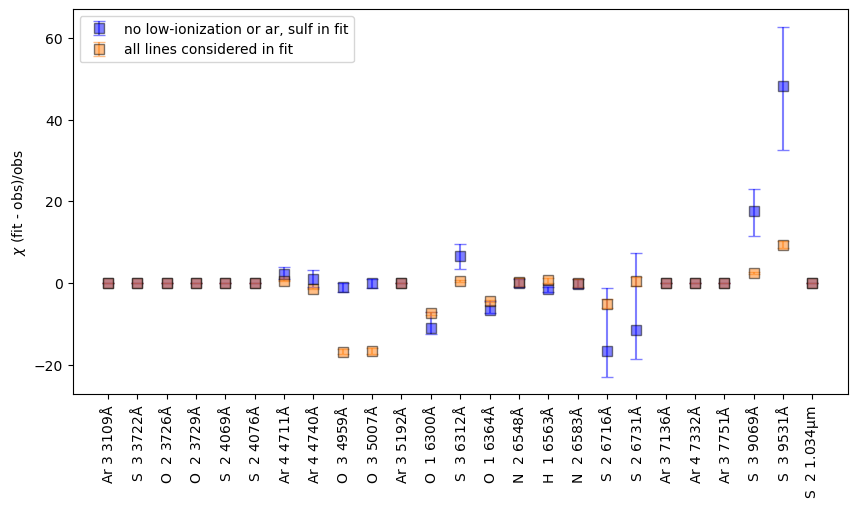

In [6]:
plt.figure(figsize=(10,5))
plt.errorbar(line_names, linechi_med,
                           yerr=[linechi_med-linechi_low, linechi_up-linechi_med],
                           color='blue', marker='s', markersize=7, linestyle=' ', 
                           markeredgecolor='k', alpha=0.5, capsize=4,label = "no low-ionization or ar, sulf in fit")
plt.errorbar(line_names_full, linechi_med_full,
                           yerr=[linechi_med_full-linechi_low_full, linechi_up_full-linechi_med_full],
                           color='tab:orange', marker='s', markersize=7, linestyle=' ', 
                           markeredgecolor='k', alpha=0.5, capsize=4,label = "all lines considered in fit")
plt.ylabel(r'$\chi$ (fit - obs)/obs');
plt.xticks(rotation=90)
plt.legend()
plt.show()